# Reconstruction of volume from simulated data

In [1]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
site.addsitedir('..')
from jax.config import config

config.update("jax_enable_x64", True)

In [2]:
import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
from src.utils import *
from src.projection import project_spatial, project, rotate_z0
from src.interpolate import *
from src.jaxops import *
from src.fsc import *
from src.algorithm import *
from src.ab_initio import ab_initio, ab_initio_mcmc
from src.residual import get_volume_residual
import jax
from jax import random

from external.pyem.project import project as project_pyem
from external.pyem.pyem import star
from external.pyem.pyem import vop
from pyfftw.builders import irfft2
from tqdm import tqdm

plt.rcParams["figure.figsize"]=8,8

### Generate the volume

Text(0.5, 1.0, 'Volume_comp MIP')

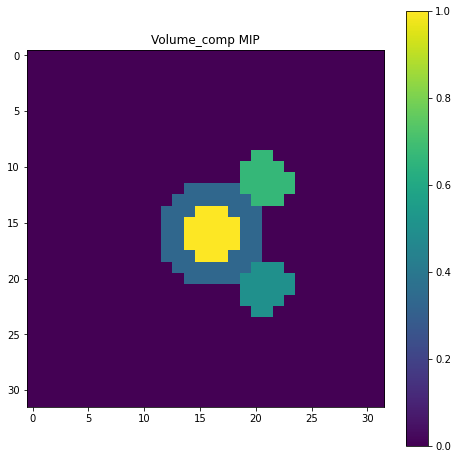

In [3]:
nx = 32
shape = np.array([nx,nx,nx])
dimensions = np.array([20,20,20])
pixel_size = dimensions[0]/shape[0]

# A volume with components
centres = np.array([[0,0,0], [3, 3, 0], [3, -3, 0], [0,0,3]])
radii = np.array([3, 1.5, 1.5, 1.5])
intensities = np.array([10,15,20, 20])

vol = jnp.array(volume_comp(shape, dimensions, centres, radii, intensities, False))
vol_fourier, x_grid, _ = volume_fourier(vol, pixel_size)

y_grid = x_grid
z_grid = x_grid

mip_z(vol)
#plt.imshow(v[:,:,int(np.floor(v.shape[2]/2))])
plt.colorbar()
plt.title('Volume_comp MIP')

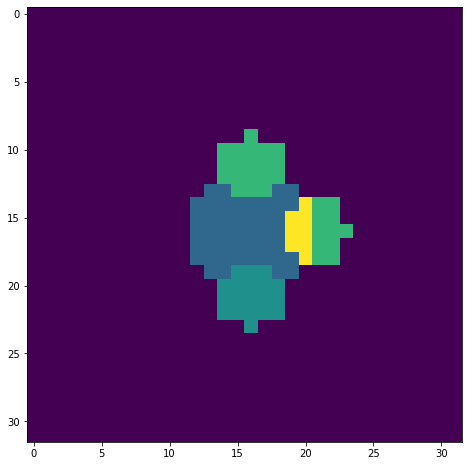

In [4]:
mip_y(vol)

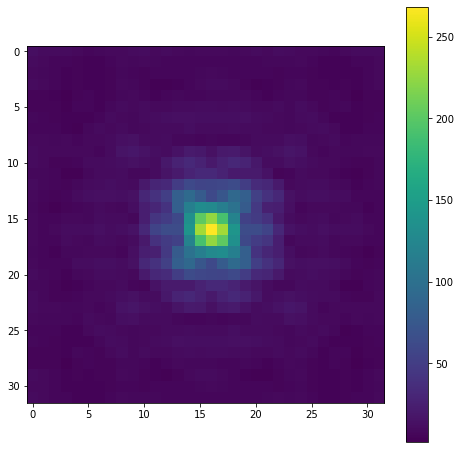

In [5]:
mip_z(jnp.fft.fftshift(jnp.abs((vol_fourier)))); plt.colorbar()

### Generate the data

CTF

In [6]:
df = star.parse_star("../external/pyem/pyem.star", keep_index = False)
dfiter = df.iterrows()
_, p = next(dfiter)

#ctf_params = {'def1'  : p[star.Relion.DEFOCUSU], 
#              'def2'  : p[star.Relion.DEFOCUSV],
#              'angast': p[star.Relion.DEFOCUSANGLE], 
#              'phase' : p[star.Relion.PHASESHIFT],
#              'kv'    : p[star.Relion.VOLTAGE],
#              'ac'    : p[star.Relion.AC], 
#              'cs'    : p[star.Relion.CS], 
#              'bf'    : 0,
#              'lp'    : 2 * pixel_size}

ctf_params0 = np.array([p[star.Relion.DEFOCUSU],
                      p[star.Relion.DEFOCUSV],
                      p[star.Relion.DEFOCUSANGLE], 
                      p[star.Relion.PHASESHIFT],
                      p[star.Relion.VOLTAGE],
                      p[star.Relion.AC],
                      p[star.Relion.CS],
                      0,
                      2 * pixel_size])

/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:531: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_INDEX], df[UCSF.IMAGE_PATH] = \
/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:539: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_ORIGINAL_INDEX], df[UCSF.IMAGE_ORIGINAL_PATH] = \


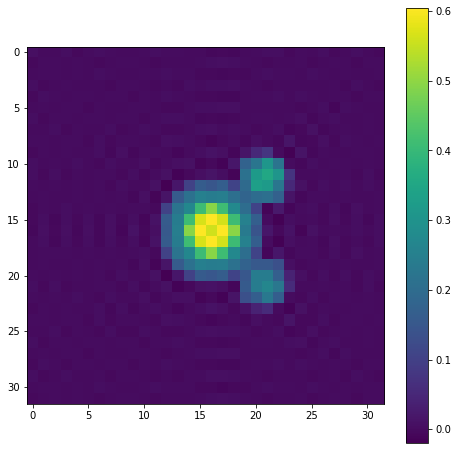

In [7]:
radius = 0.8
mask = create_3d_mask(x_grid, (0,0,0),radius)
#mip_z(jnp.fft.fftshift(mask)); plt.colorbar()

slice_func,slice_func_array, slice_func_array_angles = get_slice_funcs(project, x_grid, mask, "nn")
s = 17
img = slice_func(0.1*vol_fourier, [0,0,0], [0,0], None)
img_r = jnp.fft.fftshift(jnp.real(jnp.fft.ifft2((img.reshape([nx,nx]))))) 
plt.imshow(img_r); plt.colorbar()

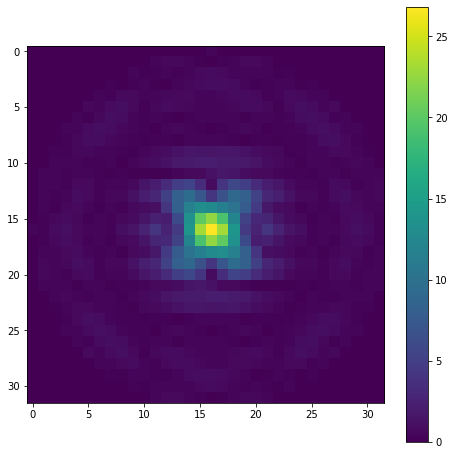

In [8]:
img_f0 = jnp.fft.fftshift(img.reshape([nx,nx]))
plt.imshow(jnp.abs(img_f0));plt.colorbar()

Generate projections (in Fourier domain)

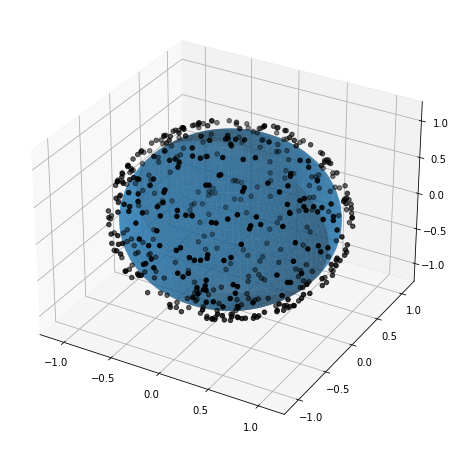

In [9]:
# Orientations
N = 10000

#s = 0.05
s = 0.1
angles_true = generate_uniform_orientations(N)
#jnp.array(np.random.rand(N,3))*jnp.pi*2

#angles_true = jnp.array(np.random.rand(N,3))*jnp.pi/4 + jnp.pi

# Non uniformly distributed orientations (here, two clusters)
#angles_true = s*np.random.randn(int(N),3)
#angles_true = np.concatenate([s*np.random.randn(2250,3), 
#                             s*np.random.randn(2250,3)+np.pi*2/3, 
#                              np.random.rand(500,3)*jnp.pi*2
#                             ], axis=0)
#np.random.shuffle(angles_true)
#angles_true = jnp.array(angles_true)

#angles_true = np.zeros([N,3])
#angles_true[:,1] = s*np.random.randn(N) - np.pi/2
#angles_true = jnp.array(angles_true)

plot_angles(angles_true[:500])

SNR = 0.1569127100502359
sigma = 37.84951113740295


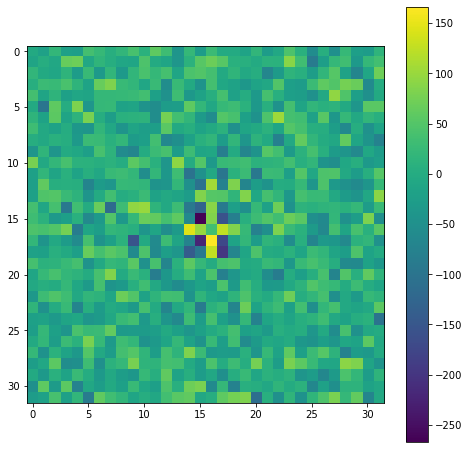

In [10]:
radius = 0.8
mask = create_3d_mask(x_grid, (0,0,0),radius)
#mip_z(jnp.fft.fftshift(mask)); plt.colorbar()

slice_func,slice_func_array, slice_func_array_angles = get_slice_funcs(project, x_grid, mask, "nn")

img0 = slice_func(vol_fourier, [0,0,0], [0,0], ctf_params0)


shifts_true = jnp.zeros([N,3])
ctf_params = jnp.array([ctf_params0] * N)
start = time.time()
imgs = slice_func_array(vol_fourier, angles_true, shifts_true, ctf_params)

# If too many images which don't fit in the gpu memory, do this:
#imgs = jnp.array([slice_func(vol_fourier, angles_true[i], shifts_true[i], ctf_params0) for i in range(N)])

norm0sq = jnp.real(jnp.sum(jnp.conj(imgs)*imgs))

# Noise
sigma = 0.2 * jnp.max(jnp.abs(img0))
imgs += (np.random.randn(N, nx*nx) + 1j*np.random.randn(N, nx*nx)) * sigma

norm1sq = jnp.real(jnp.sum(jnp.conj(imgs)*imgs))

#print(time.time()-start)

#SNR
print("SNR =", norm0sq/norm1sq)
print("sigma =", sigma)

plt.imshow(jnp.fft.fftshift(jnp.real(imgs[103].reshape(nx,nx)))); plt.colorbar()

### Crop images and volume:

In [11]:
old_nx = jnp.sqrt(imgs.shape[1]).astype(jnp.int64)
nx = 32

if old_nx > 32:
    imgs = imgs.reshape(imgs.shape[0], old_nx, old_nx)
    imgs, x_grid = crop_fourier_images(imgs, x_grid, nx)
    imgs = imgs.reshape(imgs.shape[0], nx*nx)
    #imgs2 = imgs2.reshape(imgs2.shape[0], nx*nx)

    vol_fourier, _ = crop_fourier_volume(vol_fourier, x_grid, nx)

    y_grid = x_grid
    z_grid = x_grid

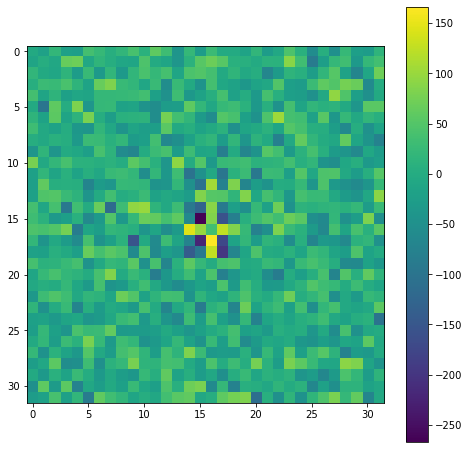

In [12]:
plt.imshow(jnp.fft.fftshift(jnp.real(imgs[103].reshape(nx,nx)))); plt.colorbar()

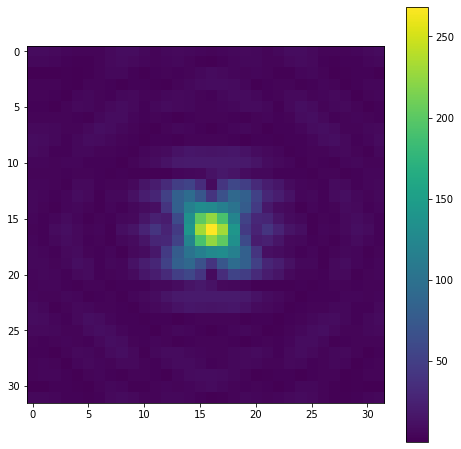

In [13]:
#mip_z(jnp.fft.fftshift(jnp.abs((vol_fourier)))); plt.colorbar()
plt.imshow(jnp.fft.fftshift(jnp.abs((vol_fourier[:,:,0])))); plt.colorbar()

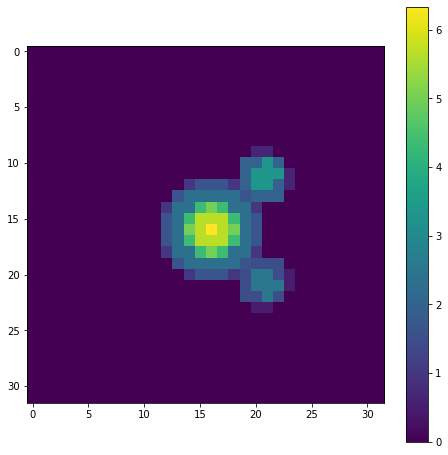

In [14]:
#mip_z(jnp.fft.fftshift(jnp.real(jnp.fft.ifftn(vol_fourier)))); plt.colorbar()
plt.imshow(jnp.fft.fftshift(jnp.real(jnp.fft.ifftn(vol_fourier[:,:,0])))); plt.colorbar()

### Loss functions for the new dimension

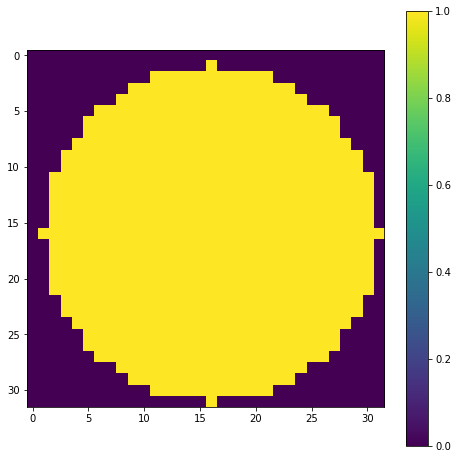

In [15]:
alpha = 0.01
#alpha = 1/N

#radius = 0.4 # for nx=16
radius = 0.75 # for nx=32
#radius = 1.6 # for nx=64
#radius = 3.2 # for nx=128
mask = create_3d_mask(x_grid, (0,0,0),radius)
mip_z(jnp.fft.fftshift(mask)); plt.colorbar()

slice_func,slice_func_array, slice_func_array_angles = get_slice_funcs(project, x_grid, mask, "tri")

loss_func, loss_func_batched, loss_func_sum, _ = get_loss_funcs(slice_func, alpha = alpha)
grad_loss_volume, grad_loss_volume_sum = get_grad_v_funcs(loss_func, loss_func_sum)

In [16]:
sigma_noise = jnp.ones(nx*nx) * sigma

In [17]:
start = time.time()
ll = loss_func_batched(vol_fourier, angles_true[:20], shifts_true[:20], ctf_params[:20], imgs[:20], sigma_noise)
#ll = loss_func_batched(np.random.randn(nx,nx,nx), angles_true[:20], shifts_true[:20], ctf_params[:20], imgs[:20])
print(time.time()-start)
print(ll.shape)

5.091156721115112
(20,)


Gradients with respect to volume pixels, over all (or a batch of) images

In [18]:
start = time.time()
ll = grad_loss_volume(np.random.randn(nx,nx,nx), angles_true[0],  shifts_true[0], ctf_params[0], imgs[0], sigma_noise)
print(time.time()-start)
print(ll.shape)

1.8174114227294922
(32, 32, 32)


In [19]:
batch_size = N
idx = np.random.default_rng().choice(N, size=batch_size, replace = False)

start = time.time()
ll = grad_loss_volume_sum(np.random.randn(nx,nx,nx), angles_true[idx], shifts_true[idx], ctf_params[idx], imgs[idx], sigma_noise)
print(time.time()-start)
print(ll.shape)

2.5088953971862793
(32, 32, 32)


### MCMC - vol

In [20]:
vol_fourier.shape

(32, 32, 32)

In [21]:
def plot_true_vs_estimated(vol_true, vol_estimated):

    plt.rcParams["figure.figsize"]=16,16
    plt.subplot(2,2,1)
    plt.imshow(jnp.abs(jnp.fft.fftshift(vol_true[:,:,0]))); plt.colorbar()
    plt.title('True')
    plt.subplot(2,2,2)
    plt.imshow(jnp.abs(jnp.fft.fftshift(vol_estimated[:,:,0]))); plt.colorbar()
    plt.title('Sampled')
    plt.subplot(2,2,3)
    plt.imshow(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vol_true[:,:,0])))); 
    plt.colorbar()
    plt.title('True')
    plt.subplot(2,2,4)
    plt.imshow(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vol_estimated[:,:,0])))); 
    plt.colorbar()
    plt.title('Estimated')

    plt.rcParams["figure.figsize"]=8,8

In [21]:
#alpha = 1e-10
#alpha = 0.001

radius_mask = 0.4 # nx=16
#radius = 0.8 # for nx=32
#radius = 1.6 # for nx=64
#radius = 3.2 # for nx=128)
mask = create_3d_mask(x_grid, (0,0,0), radius_mask)
#mip_z(jnp.fft.fftshift(mask)); plt.colorbar()

slice_func,slice_func_array, slice_func_array_angles = get_slice_funcs(project, x_grid, mask, "tri")

loss_func, loss_func_batched, loss_func_sum, _ = get_loss_funcs(slice_func, alpha = alpha)
grad_loss_volume, grad_loss_volume_batched, grad_loss_volume_sum = get_grad_v_funcs(loss_func, loss_func_sum)

logPi = lambda v : -loss_func_sum(v, angles_rec, shifts_true, ctf_params, imgs, 1)
gradLogPi = lambda v : -jnp.conj(grad_loss_volume_batched(v, angles_rec, shifts_true, ctf_params, imgs, 1))

ValueError: not enough values to unpack (expected 3, got 2)

In [32]:
alpha

0.001

In [38]:
N_mc_samples = 200
key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))
v0 = jnp.array(np.random.randn(nx,nx,nx) + 1j * np.random.randn(nx,nx,nx)) 
#v0 = v_rec

proposal_params_mala = {"tau" : 0.005, "gradLogPi" : gradLogPi}
proposal_params_hmc = {"dt" : 0.5, "L" : 10, "gradLogPi" : gradLogPi}

v_hmc_mean, r_hmc, v_hmc_samples = mcmc(key, N_mc_samples, proposal_hmc, logPi, v0, proposal_params_hmc)
v_hmc_mean = v_hmc_mean * mask

  MC sample 20 , loss (of mean) = 111218.5298943535
  MC sample 40 , loss (of mean) = 111050.66923236918
  MC sample 60 , loss (of mean) = 111013.48602832021
  MC sample 80 , loss (of mean) = 110995.05622256744
  MC sample 100 , loss (of mean) = 110988.3492350293
  MC sample 120 , loss (of mean) = 110985.07786810756
  MC sample 140 , loss (of mean) = 110977.37628528157
  MC sample 160 , loss (of mean) = 110967.4809495648
  MC sample 180 , loss (of mean) = 110954.68277686303


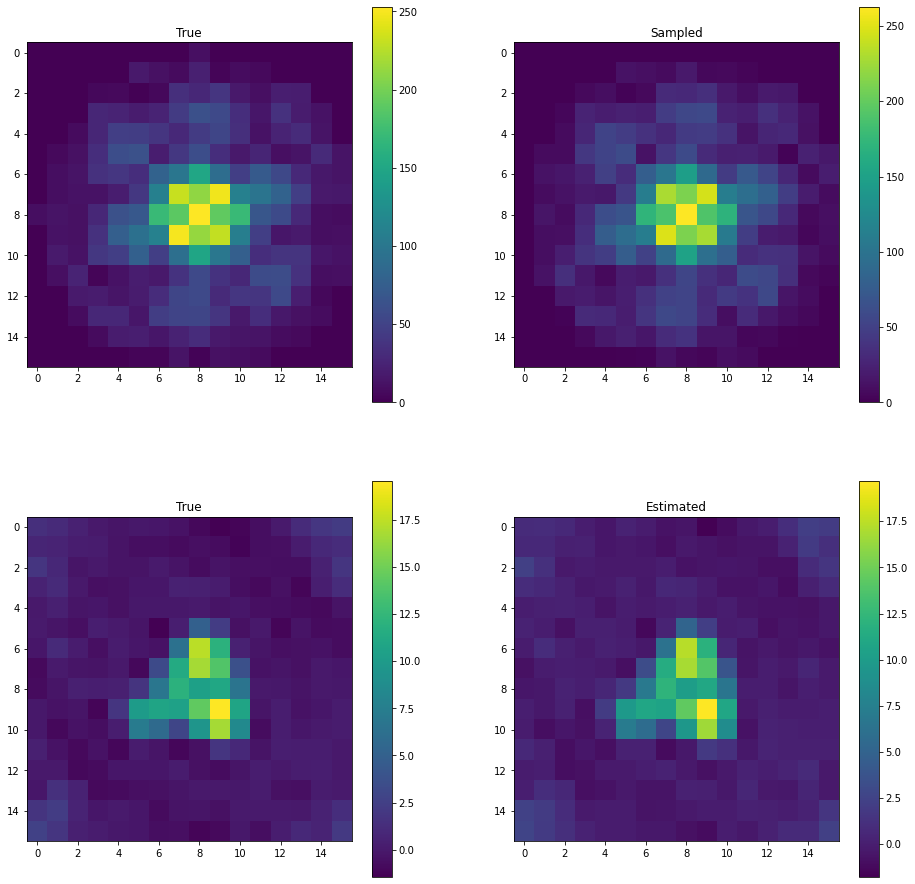

In [39]:
plot_true_vs_estimated(v_hmc_mean, v_rec)

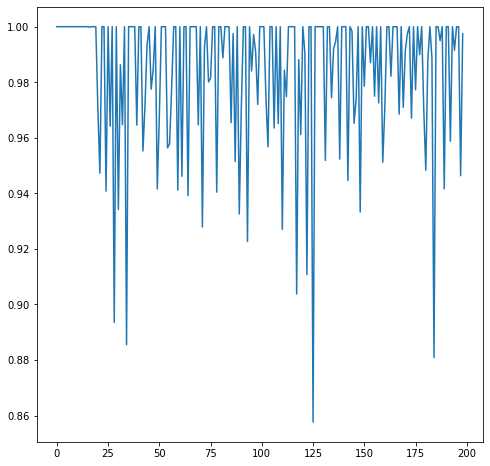

In [40]:
plt.plot(r_hmc)

In [41]:
print(loss_func_sum(vol_fourier, angles_true, shifts_true, ctf_params, imgs, 1))
print(loss_func_sum(v_hmc_mean, angles_rec, shifts_true, ctf_params, imgs, 1))
print(loss_func_sum(v_rec, angles_rec, shifts_true, ctf_params, imgs, 1))
print(loss_func_sum(vcg1, angles_rec, shifts_true, ctf_params, imgs, 1))

106923.57461857852
110571.11937895798
110718.89322055243
112065.45379450303


### MCMC - orientations

In [29]:
alpha0 = 0

radius = 0.4
mask = create_3d_mask(x_grid, (0,0,0),radius)
#mip_z(jnp.fft.fftshift(mask)); plt.colorbar()

slice_func,slice_func_array, slice_func_array_angles = get_slice_funcs(project, x_grid, mask, "tri")
loss_func, loss_func_batched, loss_func_sum, _ = get_loss_funcs(slice_func, alpha = alpha0)
logPi_batch = lambda a : -loss_func_batched(vol_fourier, a, shifts_true, ctf_params, imgs, 1)

In [30]:
key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))
N_mc_samples = 161

angles0 = generate_uniform_orientations_jax(key, N)
empty_params = {}
angles_mean, r_samples_angles, samples_angles = mcmc(key, N_mc_samples, proposal_uniform_orientations, logPi_batch, angles0, empty_params, N)

angles_rec = samples_angles[N_mc_samples-2]

  MC sample 20 , loss = 2257.7372104141664
  MC sample 40 , loss = 2129.9797624006956
  MC sample 60 , loss = 2065.0002778033004
  MC sample 80 , loss = 2024.1355119371908
  MC sample 100 , loss = 1990.1653859341927
  MC sample 120 , loss = 1962.461558508752
  MC sample 140 , loss = 1941.4619092026344
  MC sample 160 , loss = 1925.7721311507762


In [31]:
key, *keys = random.split(key, N_mc_samples + 1)
angles0 = generate_uniform_orientations_jax(key, N)
#print(jnp.mean(loss_angles(angles0))/(nx*nx*jnp.max(jnp.abs(imgs))))
print(jnp.max(jnp.abs(logPi_batch(angles0))))

for i in range(N_mc_samples):
    angles1 = mcmc_batch_step(keys[i], N_mc_samples, logPi_batch, angles0)
    angles0 = angles1
    
    if jnp.mod(i, 50) == 0:
        #loss_i = jnp.mean(loss_angles(angles1))/(nx*nx*jnp.max(jnp.abs(imgs)))
        loss_i = jnp.max(jnp.abs(logPi_batch(angles1)))
        print("Iter", i, ", loss = " ,loss_i)

5154.724529132499
Iter 0 , loss =  4627.560487737304
Iter 50 , loss =  3005.1714533481063
Iter 100 , loss =  2779.708275951956
Iter 150 , loss =  2779.708275951956


In [213]:
angles0 = generate_uniform_orientations_jax(key, N)

print(jnp.max(jnp.abs(logPi_batch(angles0))))
print(jnp.max(jnp.abs(logPi_batch(angles_true))))
print(jnp.max(jnp.abs(logPi_batch(angles1))))
print(jnp.max(jnp.abs(logPi_batch(angles_rec))))

40047.454800612046
37088.50438568081
37937.04160928529
39236.04527685738


### Ab initio

In [ ]:
key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))

N_samples = 1000
N_iter = 1000

dr = 0.05
radius = 0.2
alpha = 0.001
#alpha = 1e-10

use_sgd = True

N_cg_iter = 1000

N_sgd_iter = 310
batch_size = 500
learning_rate = 1
P = None

if use_sgd:
    N_vol_iter = N_sgd_iter
else:
    N_vol_iter = N_cg_iter

N_samples_angles = 100
N_samples_vol = 100
    
eps_vol = 1e-3

# HMC params
dt = 0.5
L = 10

out_dir = '../data/'
imgs = imgs.reshape([N, nx*nx])
#v_rec, angles_rec = ab_initio(project, imgs, sigma_noise, shifts_true, ctf_params, x_grid, use_sgd, N_iter, N_vol_iter, learning_rate, batch_size, P, N_samples, radius, dr, alpha, eps_vol, 'tri', True, True, True, out_dir)
v_rec, angles_rec = ab_initio_mcmc(key, project, imgs, sigma_noise, shifts_true, ctf_params, x_grid, use_sgd, N_iter, learning_rate, batch_size, P, N_samples_angles, N_samples_vol, dt, L, radius, dr, alpha, eps_vol, 'tri', True, True, True, out_dir)

In [20]:
imgs.ndim

2

In [ ]:
plt.imshow(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec[:,:,0])))); plt.colorbar()

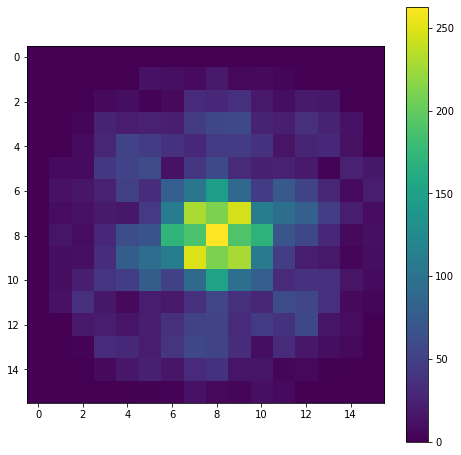

In [22]:
plt.imshow(jnp.abs(jnp.fft.fftshift(v_rec[:,:,0]))); plt.colorbar()

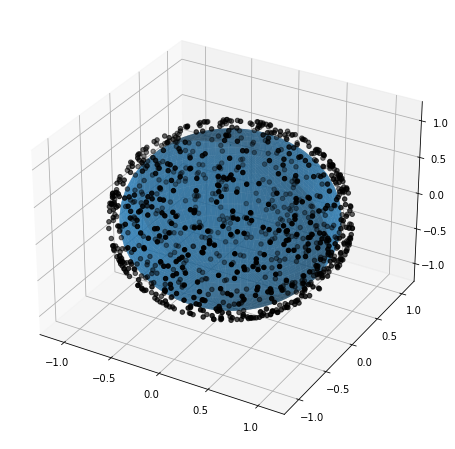

In [23]:
plot_angles(angles_rec[:1000])

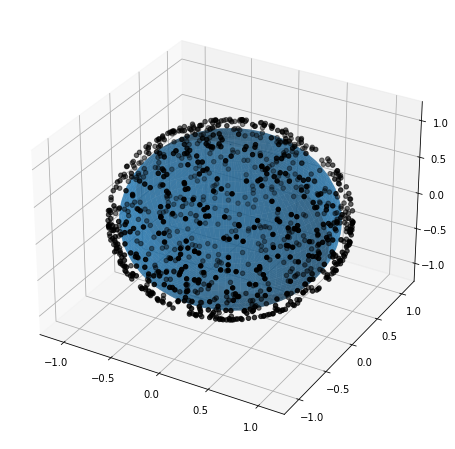

In [24]:
plot_angles(angles_true[:1000])

## Optimization with respect to volume

### CG - applied to two halves of the data

In [43]:
v0 = jnp.array(np.random.randn(nx,nx,nx) + 1j * np.random.randn(nx,nx,nx))
N_iter = 600
eps_cg = 1e-5

N2 = jnp.floor(N/2).astype(jnp.int64)
#N2 = 100000
AA1, Ab1 = get_cg_vol_ops(grad_loss_volume_sum, angles_true[:N2], shifts_true[:N2], ctf_params[:N2], imgs[:N2], v0.shape)

vcg1,_ = conjugate_gradient(AA1, Ab1, v0, N_iter, eps_cg, verbose = True)

  cg iter 0 ||r|| = 64.0999131168545
  cg iter 50 ||r|| = 0.00022445505923135778
  cg iter 100 ||r|| = 9.904533574292494e-05
  cg iter 150 ||r|| = 5.536797285466404e-05
  cg iter 200 ||r|| = 3.191014759157713e-05
  cg iter 250 ||r|| = 2.6158492823062747e-05
  cg iter 300 ||r|| = 2.5489091313994322e-05
  cg iter 350 ||r|| = 2.5521880315329098e-05
  cg iter 400 ||r|| = 2.2327517957044257e-05
  cg iter 450 ||r|| = 1.8715437013090208e-05
  cg iter 500 ||r|| = 1.5610226409670588e-05
  cg iter 550 ||r|| = 1.5686219118109472e-05


In [45]:
AA2, Ab2 = get_cg_vol_ops(grad_loss_volume_sum, angles_true[N2:], shifts_true[N2:], ctf_params[N2:], imgs[N2:], v0.shape)

vcg2, _ = conjugate_gradient(AA2, Ab2, v0, N_iter, eps_cg, verbose = True)

  cg iter 0 ||r|| = 73.69929948438595
  cg iter 50 ||r|| = 0.00016700125237854795
  cg iter 100 ||r|| = 5.8671104429629774e-05
  cg iter 150 ||r|| = 3.586747732177588e-05
  cg iter 200 ||r|| = 3.0431897624318876e-05
  cg iter 250 ||r|| = 2.370623291835185e-05
  cg iter 300 ||r|| = 2.339111653712353e-05
  cg iter 350 ||r|| = 2.5356056414641797e-05
  cg iter 400 ||r|| = 2.201810842703514e-05
  cg iter 450 ||r|| = 2.1754316144376644e-05
  cg iter 500 ||r|| = 1.778383940300002e-05
  cg iter 550 ||r|| = 1.6398462698863898e-05


In [44]:
#print("Final loss function = ", loss_func_sum(vcg, angles_true, shifts_true, ctf_params, imgs))
print("Relative error = ", jnp.max(jnp.abs((vcg1 - vol_fourier)/jnp.max(vol_fourier))))
print("Absolute error = ", jnp.mean(jnp.abs((vcg1 - vol_fourier))))

Relative error =  0.4922433392098166
Absolute error =  3.662052789934649


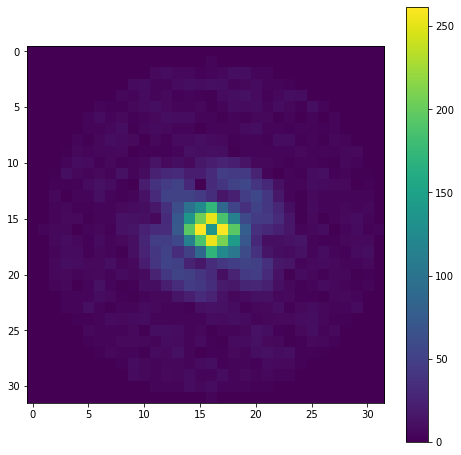

In [45]:
#mip_z(jnp.abs(jnp.fft.fftshift((vcg1)))) ; 
plt.imshow(jnp.abs(jnp.fft.fftshift((vcg1[0,:,:])))) ; 
plt.colorbar()

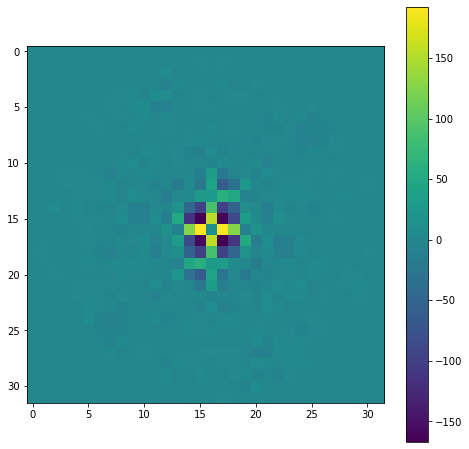

In [46]:
idx = 709

s0 = slice_func(vcg1, angles_true[idx], shifts_true[idx], ctf_params[idx])
plt.imshow(jnp.fft.fftshift(jnp.real(s0).reshape(nx,nx))); plt.colorbar()

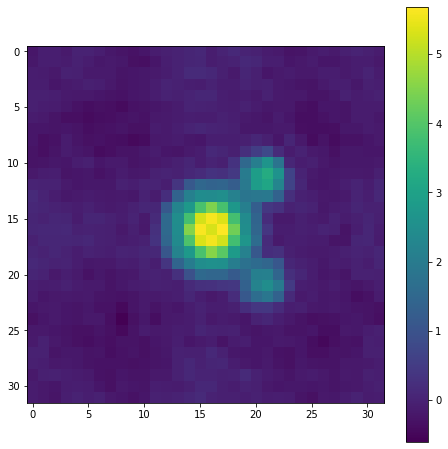

In [48]:
#mip_y(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcg1))))
plt.imshow(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcg1[:,:,0]))))
plt.colorbar()
#plt.title('Reconstruction slice')

Text(0.5, 1.0, 'Reconstruction MIP')

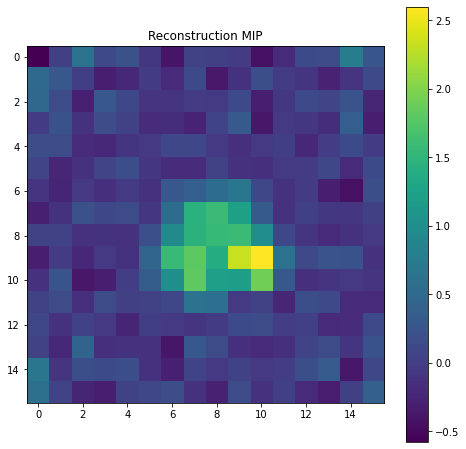

In [212]:
#mip_z(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcg2))))
plt.imshow(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec[0,:,:]))))
plt.colorbar()
plt.title('Reconstruction MIP')

Text(0.5, 1.0, 'Reconstruction relative error (Fourier)')

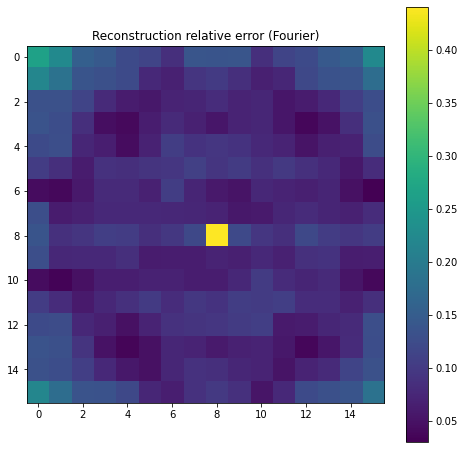

In [64]:
mip_z(jnp.abs(jnp.fft.fftshift((vcg1-vol_fourier)/jnp.max(vol_fourier))));plt.colorbar()

plt.title("Reconstruction relative error (Fourier)")

Text(0.5, 1.0, 'Error in spatial domain with low freq vol - MIP')

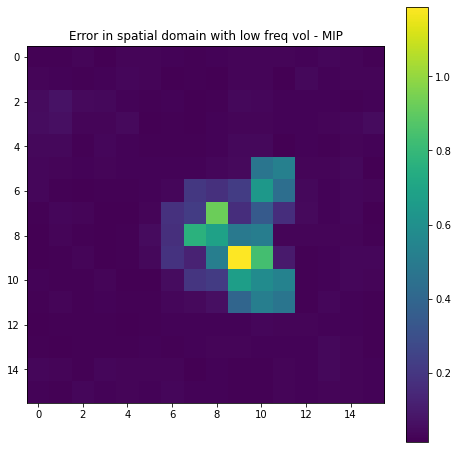

In [198]:
mip_z(jnp.abs(jnp.fft.fftshift(jnp.fft.ifftn((vol_fourier - vcg1)))))
plt.colorbar()
plt.title('Error in spatial domain with low freq vol - MIP')

In [45]:
vr = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_hmc_mean)))

with mrcfile.new('../data/simulated_rec_vhmc.mrc', overwrite=True) as mrc:
    mrc.set_data(vr.astype(np.float32))

In [46]:
vr = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vol_fourier)))

with mrcfile.new('../data/simulated_vol_16.mrc', overwrite=True) as mrc:
    mrc.set_data(vr.astype(np.float32))

### FSC

In [163]:
res, fsc, shell_points = calc_fsc(vcg1, v_hmc_max, x_grid, dr = 0.05)

In [164]:
points_v_tri = points_orientations_tri(angles_true[:int(N/2)], int(x_grid[1]))
#points_v_nn = points_orientations_nn(angles_true, x_grid[1])

Rotating coordinates
Finding point indices
Splitting in batches.
Adding up number of points from batches.


In [ ]:
#points_v_nn = points_orientations_nn(angles_true, x_grid[1])

In [166]:
res_spu, spu_tri = shell_points_used(points_v_tri, x_grid, dr = 0.05)

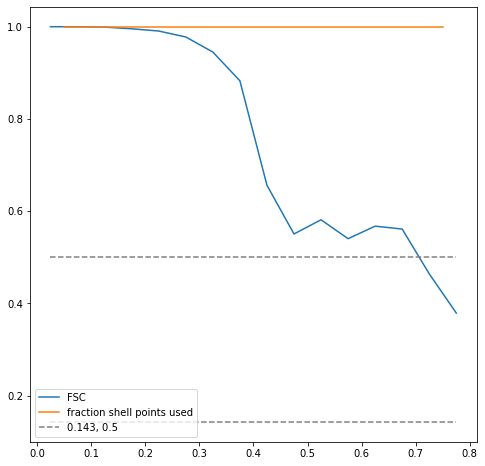

In [167]:
plt.plot(res, fsc)
plt.plot(res_spu, spu_tri)
plt.hlines([0.143, 0.5], xmin=min(res), xmax=max(res), colors = ['gray'], linestyles=['dashed'])
plt.legend(['FSC', 'fraction shell points used', '0.143, 0.5'])
#plt.title('Clustered angles')

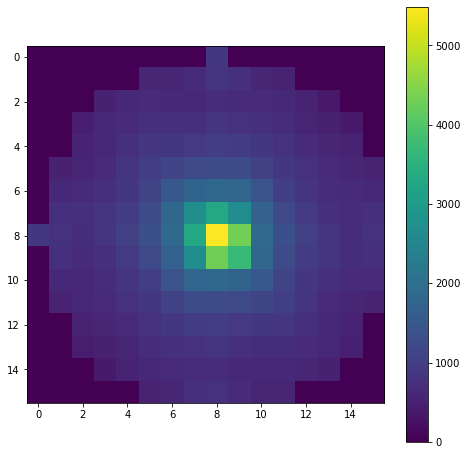

In [57]:
plt.imshow(jnp.fft.fftshift((points_v_tri[0,:,:]*mask[0,:,:]))); plt.colorbar()

In [ ]:
#res_spu, spu_nn = shell_points_used(points_v_nn, x_grid, dr = 0.05)
#plt.plot(res_spu, spu_nn)

### James

The mean is given by CG as applied above, in addition we need to calculate the variances.
The variances are given by the inverse of the gradient (AA) applied to diag(1), i.e. a volume with ones.

Looks good and agrees with counting the points above, but for whatever reason it's mirrored compared to above hmmm.

In [58]:
vones = jnp.ones(vcg1.shape)
omega = AA1(vones)
omega = 1/omega

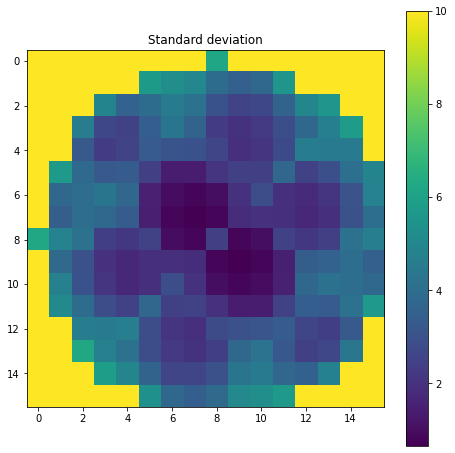

In [59]:
plt.title("Standard deviation")
plt.imshow((jnp.sqrt(jnp.abs(jnp.fft.fftshift(omega[0,:,:]))))); plt.colorbar()

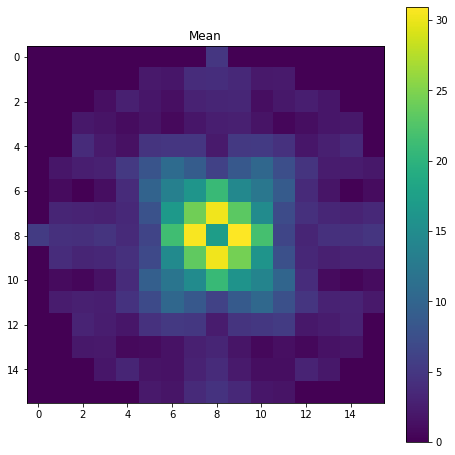

In [60]:
plt.title("Mean")
plt.imshow((jnp.abs(jnp.fft.fftshift(vcg1[:,:,0])))); plt.colorbar()

### SGD

#### A preconditioner

0.011098890110988899
1.0


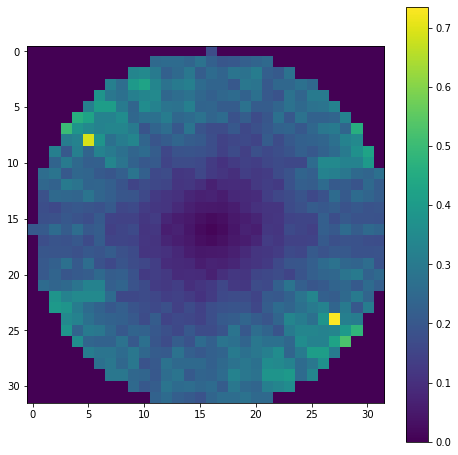

In [254]:
points_v_nn.shape
P = points_v_nn
P += 0.1
P = 1/P  * mask

P = P/jnp.max(P)

plt.imshow(jnp.fft.fftshift(P[:,:,0]));plt.colorbar()
print(P[0,0,0])
print(jnp.max(P))

In [65]:
v0 = jnp.array(np.random.randn(nx,nx,nx) + 1j * np.random.randn(nx,nx,nx))
batch_size = N/2
N_epoch = 100
eps_gd = 1e-3
learning_rate = 1
#alpha = 100000 # <- with normalized precon

sgd_grad_func = get_sgd_vol_ops(grad_loss_volume_batched, angles_true, shifts_true, ctf_params, imgs)
vgd = sgd(sgd_grad_func, N, v0, learning_rate, N_epoch, batch_size, None, eps_gd, True)

print("Final loss function (over all data) = ", jnp.mean(loss_func_batched(vgd, angles_true, shifts_true, ctf_params, imgs, 1)))
print("Relative error = ", jnp.max(jnp.abs((vgd - vol_fourier)/jnp.max(vol_fourier))))

  sgd epoch 0: mean gradient = 0.042522726770200386
  sgd epoch 10: mean gradient = 0.0030659381781304672
  sgd epoch 20: mean gradient = 0.0016716639562312395
  sgd epoch 30: mean gradient = 0.0007006905204310624


TypeError: loss_func_batched() missing 1 required positional argument: 'sigma'

Text(0.5, 1.0, 'Reconstruction relative error (Fourier)')

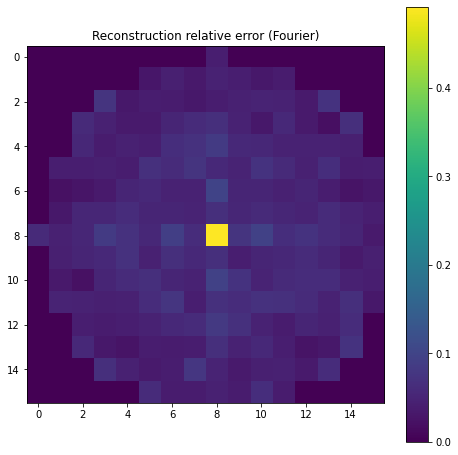

In [67]:
mip_z(jnp.abs(jnp.fft.fftshift((vgd*mask-vol_fourier*mask)/jnp.max(vol_fourier))));plt.colorbar()

plt.title("Reconstruction relative error (Fourier)")

Text(0.5, 1.0, 'Reconstruction MIP')

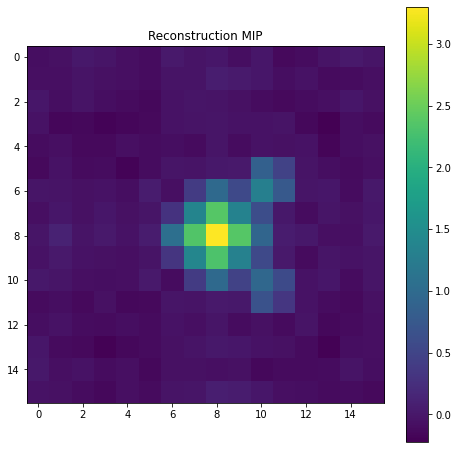

In [68]:
plt.imshow(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vgd[:,:,0]*mask[:,:,0]))))
plt.colorbar()
plt.title('Reconstruction MIP')

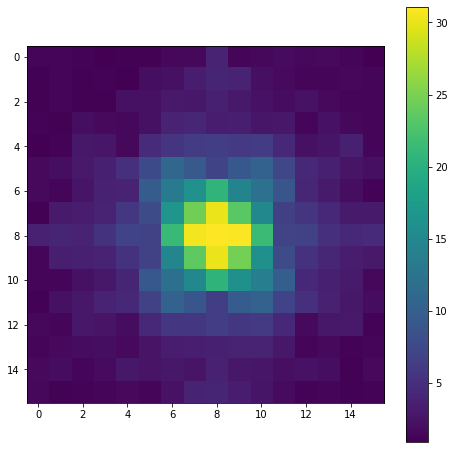

In [69]:
mip_z(jnp.abs(jnp.fft.fftshift((vgd)))) ; plt.colorbar()

Text(0.5, 1.0, 'Error in spatial domain with low freq vol - MIP')

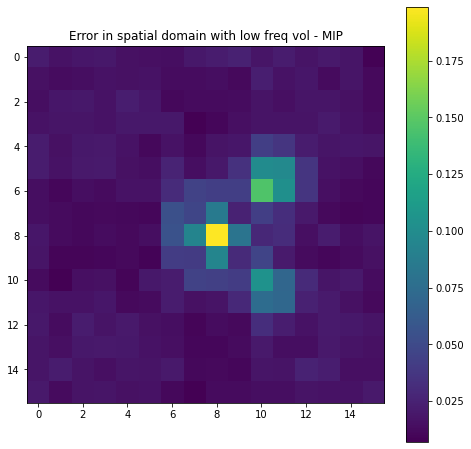

In [70]:
mip_z(jnp.abs(jnp.fft.fftshift(jnp.fft.ifftn((vol_fourier*mask - vgd*mask)))))
plt.colorbar()
plt.title('Error in spatial domain with low freq vol - MIP')

And the error with the high freq volume

Text(0.5, 1.0, 'Reconstruction error with high freq vol -  MIP')

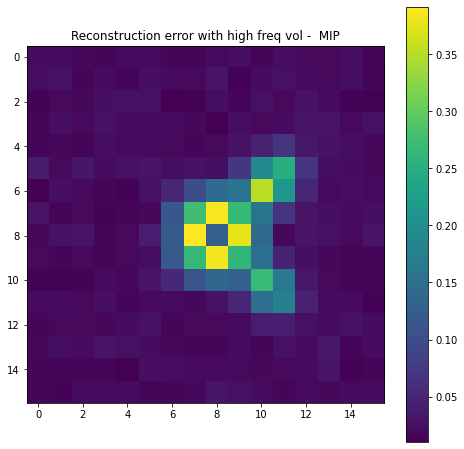

In [71]:
mip_z(jnp.abs(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vol_fourier - vgd)))))
plt.colorbar()
plt.title('Reconstruction error with high freq vol -  MIP')

Text(0.5, 1.0, 'Reconstruction error with high freq vol -  MIP')

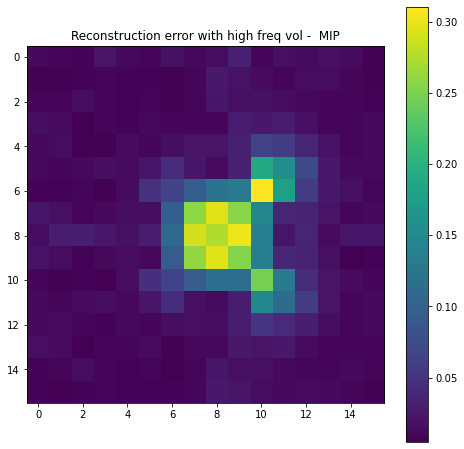

In [72]:
mip_z(jnp.abs(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vol_fourier - vol_fourier*mask)))))
plt.colorbar()
plt.title('Reconstruction error with high freq vol -  MIP')

### Volume residual

In [22]:
#alpha = 1e-10
alpha = 1e-5

radius_mask = 0.75
mask = create_3d_mask(x_grid, (0,0,0), radius_mask)
#mip_z(jnp.fft.fftshift(mask)); plt.colorbar()

slice_func,slice_func_array, slice_func_array_angles = get_slice_funcs(project, x_grid, mask, "tri")
loss_func, loss_func_batched, loss_func_sum, _ = get_loss_funcs(slice_func, alpha = alpha)
grad_loss_volume, grad_loss_volume_sum = get_grad_v_funcs(loss_func, loss_func_sum)

In [23]:
v0 = jnp.array(np.random.randn(nx,nx,nx) + 1j * np.random.randn(nx,nx,nx))
N_iter = 5000
eps_cg = 1e-5

N_train = jnp.floor(N/2).astype(jnp.int64)
AA, Ab = get_cg_vol_ops(grad_loss_volume_sum, angles_true[:N_train], shifts_true[:N_train], ctf_params[:N_train], imgs[:N_train], v0.shape, sigma_noise)

v_train,_ = conjugate_gradient(AA, Ab, v0, N_iter, eps_cg, verbose = True)

  cg iter 0 ||r|| = 0.0438027382447892
  cg iter 50 ||r|| = 4.8303001359695344e-05
  cg iter 100 ||r|| = 2.7372043812015585e-05
  cg iter 150 ||r|| = 1.8385717922028983e-05
  cg iter 200 ||r|| = 2.2919685492922857e-05
  cg iter 250 ||r|| = 1.7078214447343223e-05
  cg iter 300 ||r|| = 1.8150638896641013e-05
  cg iter 350 ||r|| = 1.47488064208539e-05
  cg iter 400 ||r|| = 1.4620664405688343e-05
  cg iter 414 ||r|| = 9.963732327016209e-06


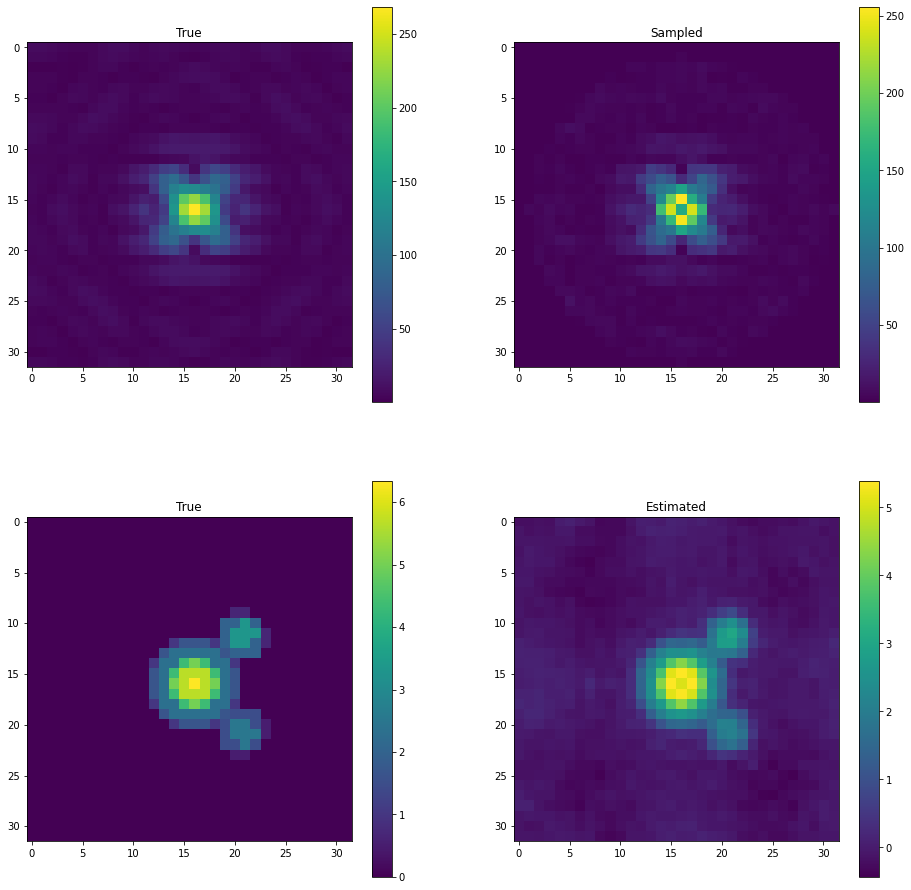

In [24]:
plot_true_vs_estimated(vol_fourier, v_train)

#### Create the volume

Set enough batches so that each batch fits in the GPU memory.
Also, more batches is better as one big batch takes ages to compile on 
the GPU.
The initial compilation takes quite a while, then it's fast.
At some point it slows down, probably to recompile (likely 
for the one batch that has a different size, although I don't
know why that happens at about 33% and not at the end).

In [ ]:
N_batches = 60000

v_resid = get_volume_residual(v_train, angles_true[N_train:], shifts_true[N_train:], ctf_params[N_train:], imgs[N_train:], x_grid, slice_func_array, N_batches)

plt.imshow(jnp.fft.fftshift(v_resid[:,:,0])); plt.colorbar()

 33%|███▎      | 19939/60000 [00:28<00:50, 799.24it/s]

In [ ]:
plt.imshow(jnp.fft.fftshift(v_resid[:,:,0]*mask[:,:,0])); plt.colorbar()

In [ ]:
v_resid_print = jnp.fft.fftshift(v_resid*mask)

with mrcfile.new('../data/resid_vol.mrc', overwrite=True) as mrc:
    mrc.set_data(v_resid_print.astype(np.float32))